### Import libraries

In [ ]:
import glob
import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, mean_squared_error, root_mean_squared_error

from scipy.stats import spearmanr

from collections import defaultdict

from tqdm import tqdm

import torch
import time
import re

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

from string import punctuation

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../scripts')
from train_utils import *

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 14


### Read the data

In [5]:
df = pd.read_parquet('../data/submissions.parquet')

In [ ]:
# keep only the test set for analysis
df = df[df['train_valid_test'] == 'test']

## Apply BERTopic

In [ ]:
# initialize the vectorizer
vectorizer_model = CountVectorizer(min_df=10,)

# fit the model
vectorizer_model.fit(df['clean_body'])

In [ ]:
# initialize the topic model
topic_model = BERTopic(nr_topics="auto",
                        vectorizer_model=vectorizer_model,
                        verbose=True,
                        )

# generate the topics
topics, probs = topic_model.fit_transform([*df['clean_body']])

2025-04-21 02:18:10,579 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/6759 [00:00<?, ?it/s]

2025-04-21 02:19:25,707 - BERTopic - Embedding - Completed ✓
2025-04-21 02:19:25,708 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-21 02:21:57,040 - BERTopic - Dimensionality - Completed ✓
2025-04-21 02:21:57,050 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

#### BERTopics to dataframe

In [12]:
# get the dataframe
topic_to_name = topic_model.get_topic_info()

# create a dictionary out of it
topic_to_name = {t:n for t,n in zip(topic_to_name['Topic'], topic_to_name['Name'])}

# bertopics to dataframe
df['bertopic'] = topic_model.topics_
df['bertopic'] = df['bertopic'].apply(lambda x: topic_to_name[x])

In [49]:
pivot = df.pivot_table(index = 'bertopic',
               values = ['ta_score', 'c_score'],
               aggfunc = ['median', 'count'])

pivot.columns = ['median_c_score', 'median_ta_score', 'count', 'temp']

pivot.drop(columns = ['temp'], inplace = True)

pivot.sort_values(['median_ta_score'], ascending = False, inplace = True)

In [51]:
med_ta, med_c = df['ta_score'].median(), df['c_score'].median()
med_ta, med_c

(0.10041386634111404, 0.20616165548563004)

In [63]:
pivot[(pivot['median_c_score'] >= med_c) & (pivot['median_ta_score'] >= med_ta)].sort_values(['count'], ascending = False)[:10]

,median_c_score,median_ta_score,count
bertopic,,,
0_ukraine_russia_putin_russian,0.491386,0.242500,2551
1_sex_she_her_relationship,0.238176,0.169218,2134
2_god_religion_atheist_religious,0.375547,0.231633,1601
3_vaccine_covid19_covid_vaccines,0.316161,0.159084,1517
6_israel_israeli_iran_iranian,0.535236,0.353800,1227
7_capitol_police_riot_officers,0.421499,0.260433,1082
9_abortion_roe_abortions_wade,0.515312,0.264545,1039
13_inflation_biden_joe_bidens,0.302680,0.148336,802
22_twitter_media_tweet_hackers,0.299954,0.145082,540


In [62]:
pivot[(pivot['median_c_score'] >= med_c) & (pivot['median_ta_score'] <= med_ta)].sort_values(['count'], ascending = False)[:10]

,median_c_score,median_ta_score,count
bertopic,,,
15_alcohol_drink_drinking_beer,0.221575,0.049109,741
19_insurance_healthcare_medical_gp,0.257375,0.055431,577
31_smell_smoking_smoke_cigarettes,0.232368,0.075769,470
38_mental_drug_medication_prescription,0.288846,0.087693,381
59_electric_tesla_ev_cars,0.243587,0.084681,303
71_meat_vegan_vegetarian_animals,0.245378,0.088205,265
76_marijuana_cannabis_weed_recreational,0.519289,0.092850,260
83_tax_taxes_irs_rich,0.342829,0.099024,242
95_introvert_introverts_extrovert_introverted,0.216384,0.041409,214


In [61]:
pivot[(pivot['median_c_score'] <= med_c) & (pivot['median_ta_score'] >= med_ta)].sort_values(['count'], ascending = False)[:10]

,median_c_score,median_ta_score,count
bertopic,,,
14_anon_hates_discovers_explains,0.103987,0.250121,791
17_tinder_profile_matches_review,0.152408,0.121505,664
21_manager_boss_fired_hr,0.191704,0.116970,550
30_uh_oh_bro_bruh,0.104034,0.160761,470
35_together_married_hes_he,0.199848,0.110907,412
67_iq_intelligence_smart_smarter,0.182768,0.128791,271
77_height_tall_taller_short,0.152901,0.126677,259
80_roast_18m_20m_worst,0.144797,0.304496,250
85_apps_dating_app_bumble,0.196501,0.119734,237


In [60]:
pivot[(pivot['median_c_score'] <= med_c) & (pivot['median_ta_score'] <= med_ta)].sample(10)

,median_c_score,median_ta_score,count
bertopic,,,
1397_architect_flat_renting_viewing,0.170747,0.025759,12
101_sunday_happy_weekend_friday,0.137800,0.037081,206
1385_grey_hairs_hair_gray,0.146261,0.063521,12
323_trades_jobs_apprentice_electrician,0.169942,0.053147,69
1253_sell_sale_garage_items,0.194592,0.024361,14
662_comedies_comedy_movies_funny,0.131134,0.034896,32
706_watches_apple_watch_detect,0.146485,0.048320,30
1317_1am_morning_waking_exploding,0.106419,0.062723,13
875_travel_theoretically_traveler_possible,0.181516,0.021585,23


### Categorize as political/other

In [ ]:
political_subreddits = ['politics', 'Conservative', 'Liberal']
FILTER_political = df['subreddit'].isin(political_subreddits)

In [ ]:
topic_analysis = {}

for FILTER, _ in zip([FILTER_political, ~FILTER_political], ['Political', 'Non-political']):
    
    # filter out only political subreddits
    temp = df[FILTER].copy()

    # pivot table
    temp = temp.pivot_table(index= 'bertopic', values=['ta_score', 'c_score'], aggfunc=['median','count'])

    # rename the columns
    temp.columns = ['c_score', 'ta_score', 'c_count', 'count']
    temp = temp.drop(columns=['c_count'])
    temp.columns = ['c_score', 'ta_score', 'count']

    # reset index and remove -1 topic
    unknown_topic = temp.index[0]
    temp = temp.loc[temp.index != unknown_topic]

    # remove topics with less than 10 counts
    temp = temp[temp['count']>=10]

    # change topic naming
    temp.index = [", ".join(i.split('_')[1:]) for i in temp.index]

    # sum the scores and sort
    temp['sum_score'] = temp['c_score'] + temp['ta_score']
    temp = temp.sort_values(['sum_score'], ascending=False)
    
    topic_analysis[_] = temp

In [ ]:
c_median = df['c_score'].median()
ta_median = df['ta_score'].median()

In [ ]:
colors = ['#1f77b4', 'orange']
color_match = {n:c for n,c in zip(['Non-political','Political'], colors)}

### Find most prevalent (populated) categories for each quadrant in TA - C plane

In [ ]:
namings = ['High Both', 'High C, Low TA', 'Low C, High TA', 'Low Both']
categories = ['Political', 'Non-political']
pivots = defaultdict(list)

for col, category in zip([0, 1], categories):
    FILTER_1 = (topic_analysis[category]['c_score']>c_median) & (topic_analysis[category]['ta_score']>ta_median)
    FILTER_2 = (topic_analysis[category]['c_score']>c_median) & (topic_analysis[category]['ta_score']<ta_median)
    FILTER_3 = (topic_analysis[category]['c_score']<c_median) & (topic_analysis[category]['ta_score']>ta_median)
    FILTER_4 = (topic_analysis[category]['c_score']<c_median) & (topic_analysis[category]['ta_score']<ta_median)
    filters = [FILTER_1, FILTER_2, FILTER_3, FILTER_4]
    
    for name, FILTER in zip(namings, filters):
        _ = topic_analysis[category][FILTER].sort_values('count', ascending=False)
        _['category'] = category
        pivots[name].append(_)

# concatenate the pivots
pivots = {k:pd.concat(v) for k,v in pivots.items()}

most_prevalent = defaultdict(list)

for k, v in pivots.items():
    for category in ['Political', 'Non-political']:
        d = v[v['category'] == category].head(30)
        d['quadrant'] = k
        most_prevalent[k].append(d)

most_prevalent = {k:pd.concat(v) for k,v in most_prevalent.items()}

# remove duplicates
most_prevalent = {k:v[~v.index.duplicated(keep='last')] for k,v in most_prevalent.items()}

# do sampling
for k, v in most_prevalent.items():

    # get the number of political topics
    N_political = len(v[v['category']=='Political'])

    # get at most 6 political topics if more than 6, else get all 
    N_political = 5 if N_political > 5 else N_political

    # get the number of non-political topics to sample
    N_other = 10 - N_political

    #most_prevalent[k] = pd.concat([v[v['category']=='Political'].head(N_political), v[v['category']=='Non-political'].head(N_other)])
    most_prevalent[k] = pd.concat([v[v['category']=='Political'].sample(N_political), v[v['category']=='Non-political'].sample(N_other)])

### Visualize

In [ ]:
for k,v in most_prevalent.items():
    v['color'] = v['category'].map(color_match)

High Both
High C, Low TA


/tmp/ipykernel_237064/2959147721.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['', .2, .4, .6])
/tmp/ipykernel_237064/2959147721.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['', .2, .4, .6])


Low C, High TA
Low Both


/tmp/ipykernel_237064/2959147721.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['', .2, .4, .6])
/tmp/ipykernel_237064/2959147721.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['', .2, .4, .6])


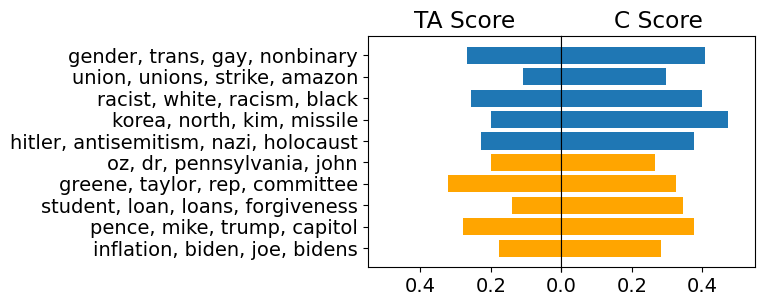

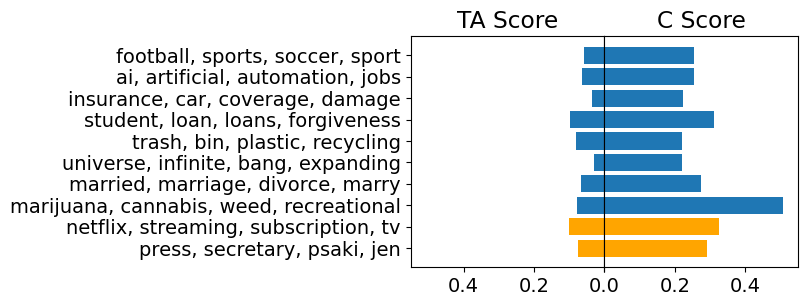

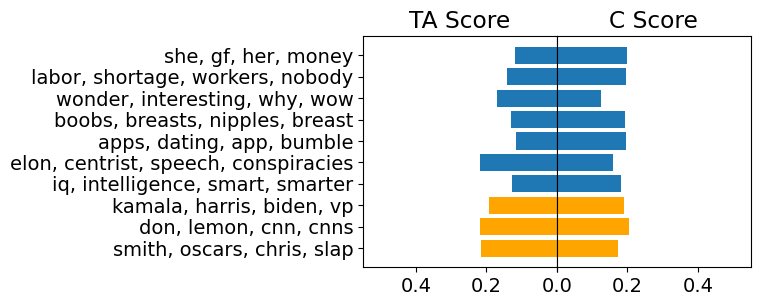

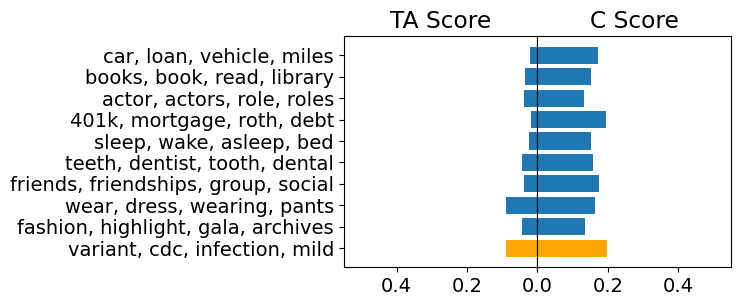

In [ ]:
index = [0,1]
x_list = ['ta_score', 'c_score']
xlabel_list = ['TA Score', 'C Score']
median_list = [ta_median, c_median]

for k, mp in most_prevalent.items():
    print(k)
    fig, axs = plt.subplots(1, 2, figsize=(5,3))
    
    for i, x, xlabel, median in zip(index, x_list, xlabel_list, median_list):
        axs[i].barh(mp.index, mp[x], color=mp['color'])
        axs[i].set_xlim(0,.55)
        axs[i].set_title(xlabel)
        #axs[i].grid(alpha=.3)

        #axs[i].axvline(median, color='black', linestyle='--', linewidth=1, alpha=.6)
        
    axs[0].invert_xaxis()
    axs[1].set_yticks([])
    axs[1].set_xticklabels(['', .2, .4, .6])

    plt.subplots_adjust(wspace=0)

    fig.savefig(f'../figures/main_fig_helpers/{k}.pdf', bbox_inches='tight')

In [ ]:
df['ta_rank'] = df['ta_score'].rank(pct=True)
df['c_rank'] = df['c_score'].rank(pct=True)

In [ ]:
df[df['bertopic'].apply(lambda x: 'climate' in x)]['bertopic'].value_counts()

bertopic
74_climate_warming_global_change      262
714_activists_climate_protests_oil     29
1074_greta_climate_protest_eco         17
1189_climate_john_envoy_frankly        15
Name: count, dtype: int64

In [ ]:
idx = 0

FILTER = (df['ta_rank'] < .5) & (df['bertopic'] == "74_climate_warming_global_change") & (df['clean_body'].apply(lambda x: 'thank' in x))
print(df[FILTER].iloc[idx]['clean_body'])
print(df[FILTER].iloc[idx]['ta_rank'])
print(df[FILTER].iloc[idx]['c_rank'])
print(df[FILTER].iloc[idx]['mean_openai'])
print(df[FILTER].iloc[idx]['ta_score'])
print(df[FILTER].iloc[idx]['submission_openai'])

cold front global warming okay so its super cold rn i couldnt help but wondering whether this is a good thing thats combatting global warming or if this is the result of global warming.. i tried to look up some stuff but didnt get anything conclusive so i decided to ask here. thanks! edit: my bad, didnt know its called climate change now 🤦🏾‍♀️
0.2810584133970761
0.7539692814144235
0.005263739837373313
0.05201836675405502
0.007799924593107712


In [ ]:
df[(df['ta_rank'] > .95) & (df['bertopic'] == "25_gender_trans_gay_nonbinary")].iloc[11]['mean_openai']

0.5427415080219761

In [ ]:
df[(df['ta_rank'] > .95) & (df['bertopic'] == "25_gender_trans_gay_nonbinary")].iloc[11]['ta_score']

0.4778905510902405

In [ ]:
df[(df['ta_rank'] > .95) & (df['bertopic'] == "25_gender_trans_gay_nonbinary")].iloc[4]['submission_openai']

0.19984344780221103